In [1]:
import tables
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
import matplotlib.pyplot as plt
from ctapipe.image import tailcuts_clean
from scipy.interpolate import griddata
from astropy import units as u
import numpy as np

In [3]:
data_path = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma-diffuse_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
data = tables.open_file(data_path)

# acquire the data
data_ainfo = data.root.Array_Info
data_einfo = data.root.Event_Info
data_LST = data.root.LST

print(repr(data_ainfo))
print(repr(data_einfo))
print(repr(data_LST))

# array info data
ai_run_array_direction = [x['run_array_direction']
                          for x in data_ainfo.iterrows()]
ai_tel_id = [x['tel_id'] for x in data_ainfo.iterrows()]
ai_tel_type = [x['tel_type'] for x in data_ainfo.iterrows()]
ai_tel_x = [x['tel_x'] for x in data_ainfo.iterrows()]
ai_tel_y = [x['tel_y'] for x in data_ainfo.iterrows()]
ai_tel_z = [x['tel_z'] for x in data_ainfo.iterrows()]

# event info data
ei_alt = [x['alt'] for x in data_einfo.iterrows()]
ei_az = [x['az'] for x in data_einfo.iterrows()]
ei_core_x = [x['core_x'] for x in data_einfo.iterrows()]
ei_core_y = [x['core_y'] for x in data_einfo.iterrows()]
ei_event_number = [x['event_number'] for x in data_einfo.iterrows()]
ei_h_first_int = [x['h_first_int'] for x in data_einfo.iterrows()]
ei_mc_energy = [x['mc_energy'] for x in data_einfo.iterrows()]
ei_particle_id = [x['particle_id'] for x in data_einfo.iterrows()]
ei_run_number = [x['run_number'] for x in data_einfo.iterrows()]
ei_LST_indices = [x['LST_indices'] for x in data_einfo.iterrows()]

# LST data
LST_event_index = [x['event_index'] for x in data_LST.iterrows()]
LST_image_charge = [x['image_charge'] for x in data_LST.iterrows()]
LST_image_peak_times = [x['image_peak_times'] for x in data_LST.iterrows()]

/Array_Info (Table(289,)) 'Table of array data'
  description := {
  "run_array_direction": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "tel_id": UInt8Col(shape=(), dflt=0, pos=1),
  "tel_type": StringCol(itemsize=8, shape=(), dflt=b'', pos=2),
  "tel_x": Float32Col(shape=(), dflt=0.0, pos=3),
  "tel_y": Float32Col(shape=(), dflt=0.0, pos=4),
  "tel_z": Float32Col(shape=(), dflt=0.0, pos=5)}
  byteorder := 'little'
  chunkshape := (2259,)
/Event_Info (Table(4853,)) 'Table of Events'
  description := {
  "alt": Float32Col(shape=(), dflt=0.0, pos=0),
  "az": Float32Col(shape=(), dflt=0.0, pos=1),
  "core_x": Float32Col(shape=(), dflt=0.0, pos=2),
  "core_y": Float32Col(shape=(), dflt=0.0, pos=3),
  "event_number": UInt32Col(shape=(), dflt=0, pos=4),
  "h_first_int": Float32Col(shape=(), dflt=0.0, pos=5),
  "mc_energy": Float32Col(shape=(), dflt=0.0, pos=6),
  "particle_id": UInt8Col(shape=(), dflt=0, pos=7),
  "run_number": UInt32Col(shape=(), dflt=0, pos=8),
  "LST_indices": Int32Col(sha

In [4]:
#e_idx = 58 , 674
e_idx = 2229
# select a spcific event
my_event = data_einfo[e_idx]
print('Event number: {}'.format(my_event['event_number']))
print('Energy: {} TeV'.format(my_event['mc_energy']))
print('Alt: {} rad'.format(my_event['alt']))
print('Az: {} rad'.format(my_event['az']))
my_indices = my_event['LST_indices']
print('LST_indices: ' + str(my_indices))

Event number: 375601
Energy: 0.9098318815231323 TeV
Alt: 1.2217304706573486 rad
Az: 6.283185005187988 rad
LST_indices: [2869 2870 2871 2872]


In [5]:
#we will take always the first lst index just for demostrations
# print event information
img_charge = LST_image_charge[my_indices[0]]
img_time = LST_image_peak_times[my_indices[0]]
print(img_charge)
print(img_time)

[-2.4409199  -0.7888425  -1.6547577  ... -1.2159475   2.3322046
 -0.56620854]
[16. 27.  0. ... 25. 26. 24.]


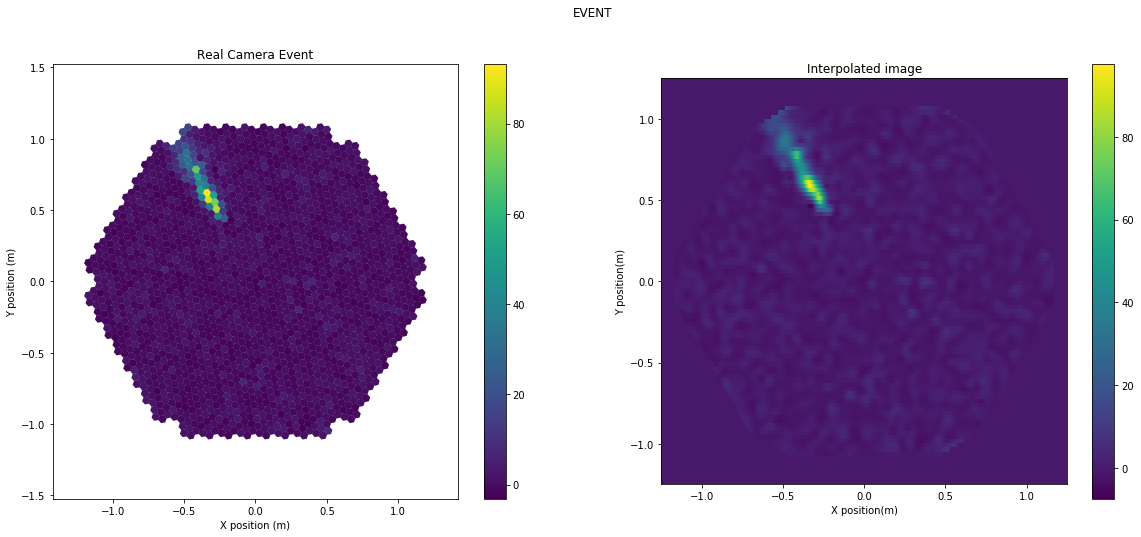

In [6]:
# Load the camera
%matplotlib inline 
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(20, 8))

plt.suptitle('EVENT')
disps = []

ax = plt.subplot(1, 2, 1)

disp = CameraDisplay(geom, ax=ax, title="Real Camera Event")
disp.add_colorbar()

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_charge, picture_thresh=10, boundary_thresh=5
)
clean = img_charge.copy()
clean[~cleanmask] = 0.0

# Show the camera image and overlay Hillas ellipse and clean
# pixels
disp.image = img_charge
# disp.cmap = 'inferno'
# disp.highlight_pixels(cleanmask, color='crimson')
disps.append(disp)

# interpolation

points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_charge)

grid_x, grid_y = np.mgrid[-1.25:1.25:1000j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

grid_z = np.nan_to_num(grid_z)

ax = plt.subplot(1, 2, 2)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inferno = plt.get_cmap('inferno')
#inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', cmap=inferno)
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower')
plt.colorbar(inter, ax=ax)
# plt.savefig('real-interp.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

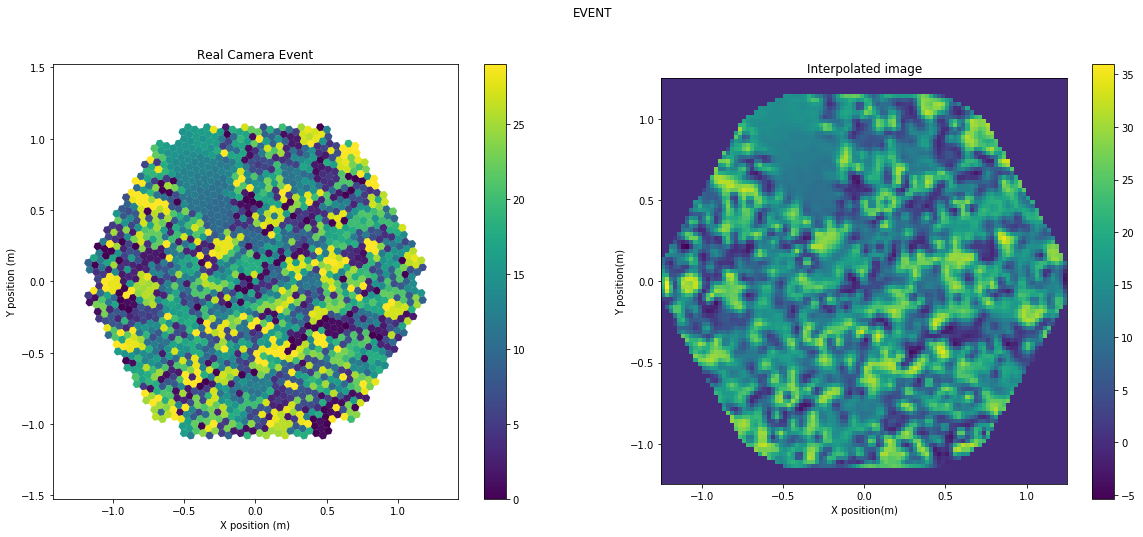

In [25]:
# Load the camera
%matplotlib inline 
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(20, 8))

plt.suptitle('EVENT')
disps = []

ax = plt.subplot(1, 2, 1)

disp = CameraDisplay(geom, ax=ax, title="Real Camera Event")
disp.add_colorbar()

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_time, picture_thresh=10, boundary_thresh=5
)
clean = img_time.copy()
clean[~cleanmask] = 0.0

# Show the camera image and overlay Hillas ellipse and clean
# pixels
disp.image = img_time
# disp.cmap = 'inferno'
# disp.highlight_pixels(cleanmask, color='crimson')
disps.append(disp)

# interpolation

points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_time)

grid_x, grid_y = np.mgrid[-1.17:1.17:100j, -1.17:1.17:100j]
#grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

grid_z = np.nan_to_num(grid_z)

ax = plt.subplot(1, 2, 2)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inferno = plt.get_cmap('inferno')
#inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', cmap=inferno)
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower')
plt.colorbar(inter, ax=ax)
#plt.savefig('real-interp-time.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

In [12]:
print(100*100 - np.count_nonzero(grid_z))

2838


In [21]:
print(grid_z[99][:])
print(grid_z.shape)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         10.08247169 10.96227746  8.35445403  4.39812008
  0.7215459  -2.05588315 -3.31732966 -2.54495115 -0.15655708  3.78830894
 10.49277887  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.     